In [4]:
%pip install --upgrade pip
%pip install --upgrade transformers
%pip install --upgrade torch
%pip install --upgrade pandas
# %pip uninstall TensorFlow

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Data Processing

In [30]:
import pandas as pd
import re
pd.set_option('display.max_colwidth',0)

In [81]:
#pd.set_option('display.max_rows', None)
df = pd.read_csv('binary_labelled_terms.csv')
df = df.drop(['Topic','Term Percentage','Term Frequency','First PMID','List of all sentences for term','List of PMIDs'], axis=1)
df = df.rename(columns={'First Sentence': 'first_sentence'})
df['Term-Label'] = df['Term-Label'].replace("general_term","noise")
def clean_text(text):
    # Remove non-breaking spaces (replace '\xa0' with a regular space)
    cleaned_text = text.replace('</i>', ' ')
    cleaned_text = cleaned_text.replace('<i>', ' ')
    # Remove extra whitespace and trim the text
    cleaned_text = ' '.join(cleaned_text.split())
    return cleaned_text
# Apply the clean_text function to your DataFrame
df['first_sentence'] = df['first_sentence'].apply(clean_text)
df = df[['Term','first_sentence','Term-Label']]
# Print the cleaned DataFrame
df.head(5)

,Term,first_sentence,Term-Label
0,pcos,Polycystic ovary syndrome (PCOS) is a gynecological endocrine disorder and the leading cause of anovulatory female infertility.,medical_term
1,infertility,The following describers were used: chlamydia trachomatis AND infertility ; chlamydia trachomatis AND tubal alteration AND infertility ; chlamydia AND low pregnancy rates .,medical_term
2,women,"In the last 20 years, aspecific auto-immunity, defined as positivity of auto-antibodies in blood sample without clinical or biological criteria for defined diseases, has been evoked in a subpopulation of infertile women.",noise
3,sperm,"Clinical management for unexplained infertility includes expectant management as well as active treatments, including ovarian stimulation (OS), intrauterine insemination (IUI), OS-IUI, and in vitro fertilisation (IVF) with or without intracytoplasmic sperm injection (ICSI).Existing systematic reviews have conducted head-to-head comparisons of these interventions using pairwise meta-analyses.",medical_term
4,review,"Hence, the goal of the present review is to contribute to a better elucidation of this matter.",medical_term


In [11]:
df = pd.read_csv('labelled_terms.csv')
df = df.drop(['Topic','Term Percentage'], axis=1)
df['Term-Label'] = df['Term-Label'].replace("general_term","noise")
def clean_text(text):
    # Remove special characters, punctuation, and extra whitespace
    cleaned_text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    # Remove non-breaking spaces (replace '\xa0' with a regular space)
    cleaned_text = cleaned_text.replace('\xa0', ' ')
    cleaned_text = cleaned_text.replace('xa0', ' ')
    # Remove extra whitespace and trim the text
    cleaned_text = ' '.join(cleaned_text.split())
    return cleaned_text
# Apply the clean_text function to your DataFrame
df['first_sentence'] = df['first_sentence'].apply(clean_text)
# Print the cleaned DataFrame
df.head(5)

,Term,first_sentence,Term-Label
0,women,In the last 20 years aspecific auto immunity defined as positivity of auto antibodies in blood sample without clinical or biological criteria for defined diseases has been evoked in a subpopulation of infertile women,noise
1,pregnancy,The direct pathogenesis of this auto immunity is unknown but therapeutic immunomodulators prescribed on a case by case basis could favor pregnancy even in cases of unexplained primary or secondary infertility,medical_term
2,risk,Meta analysis of studies that evaluated the role of NK cells in IVF outcome showed no significant difference in live birth rates in women with elevated NK cells or NK cell activity compared with women without elevated peripheral NK cells or NK cell activity NK activity assessed using a cytotoxicity assay relative risk 0,noise
3,infertility,On average 10 of infertile couples have unexplained infertility,medical_term
4,review,A systematic review was performed PUBMED using the MESH search terms infertility and auto immunity or reproductive technique or assisted reproduction or in vitro fertilization and auto immunity,noise


Some models with bio datasets

In [82]:
from transformers import pipeline, AutoTokenizer, AutoModelForTokenClassification
import seaborn as sns
import matplotlib.pyplot as plt

In [83]:
def tokenModelAndPipe(model_name):
    # Load model directly
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForTokenClassification.from_pretrained(model_name)
    # Use a pipeline as a high-level helper
    pipe = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")
    df['ner_results'] = df['first_sentence'].apply(lambda sentence: pipe(sentence))
def find_entity_group(row):
    input_string = row['ner_results']
    word_to_check = row['Term']
    for item in input_string:
        words = item.get('word', '').split()
        word_count = len(words)
        if word_to_check in words and word_count <= 3:
            return item.get('entity_group')
    return None
def get_entity_name():
    unique_words = set(word for word in df[df['Term-Label'] == 'medical_term']['entity_group'] if word is not None)
    if len(unique_words) == 1:
        result = next(iter(unique_words))
    else:
        result = "More than one entity_group corresponding to medical_term, please mark it manually."
        filtered_df = df[(df['Term-Label'] == 'medical_term') & (df['entity_group'].notnull())][['Term', 'Term-Label', 'entity_group']]
        print(filtered_df.to_string(index=False))
    return result

def get_score_print(label):
    TP = len(df[(df['Term-Label'] == 'medical_term') & (df['entity_group'] == label)])
    FP = len(df[(df['Term-Label'] == 'medical_term') & (df['entity_group'] != label)])
    FN = len(df[(df['Term-Label'] != 'medical_term') & (df['entity_group'] == label)])
    TN = len(df[(df['Term-Label'] != 'medical_term') & (df['entity_group'] != label)])
    confusion_matrix = [
        [TP, FP],
        [FN, TN]
    ]
    labels = ['medical_term', 'noise']
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Actual Label')
    plt.ylabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()
    Precision = TP / (TP + FP) if TP + FP > 0 else 0
    Recall = TP / (TP + FN) if TP + FN > 0 else 0
    F1 = 2 * (Precision * Recall) / (Precision + Recall) if Precision + Recall > 0 else 0
    print(f"Precision: {Precision}")
    print(f"Recall: {Recall}")
    print(f"F1 Score: {F1}")
    

BERT

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


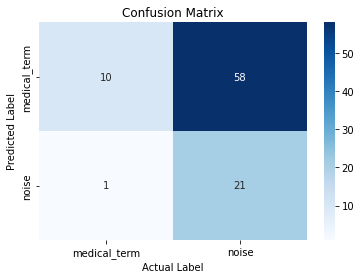

Precision: 0.14705882352941177
Recall: 0.9090909090909091
F1 Score: 0.25316455696202533


,Term,first_sentence,Term-Label,ner_results,entity_group
0,pcos,Polycystic ovary syndrome (PCOS) is a gynecological endocrine disorder and the leading cause of anovulatory female infertility.,medical_term,"[{'entity_group': 'Disease', 'score': 0.9998662, 'word': 'polycystic ovary syndrome', 'start': 0, 'end': 25}, {'entity_group': 'Disease', 'score': 0.99977654, 'word': 'pcos', 'start': 27, 'end': 31}, {'entity_group': 'Disease', 'score': 0.9997202, 'word': 'gynecological endocrine disorder', 'start': 38, 'end': 70}, {'entity_group': 'Disease', 'score': 0.99859685, 'word': 'anovulatory female infertility', 'start': 96, 'end': 126}]",Disease
1,infertility,The following describers were used: chlamydia trachomatis AND infertility ; chlamydia trachomatis AND tubal alteration AND infertility ; chlamydia AND low pregnancy rates .,medical_term,"[{'entity_group': 'Disease', 'score': 0.99958825, 'word': 'chlamydia trachomatis', 'start': 36, 'end': 57}, {'entity_group': 'Disease', 'score': 0.9996224, 'word': 'infertility', 'start': 62, 'end': 73}, {'entity_group': 'Disease', 'score': 0.99968094, 'word': 'chlamydia trachomatis', 'start': 76, 'end': 97}, {'entity_group': 'Disease', 'score': 0.99892205, 'word': 'tubal alteration', 'start': 102, 'end': 118}, {'entity_group': 'Disease', 'score': 0.99435776, 'word': 'infertility', 'start': 123, 'end': 134}, {'entity_group': 'Disease', 'score': 0.9983738, 'word': 'chlamydia', 'start': 137, 'end': 146}]",Disease
2,women,"In the last 20 years, aspecific auto-immunity, defined as positivity of auto-antibodies in blood sample without clinical or biological criteria for defined diseases, has been evoked in a subpopulation of infertile women.",noise,"[{'entity_group': 'Disease', 'score': 0.60399973, 'word': '##fer', 'start': 206, 'end': 209}]",None
3,sperm,"Clinical management for unexplained infertility includes expectant management as well as active treatments, including ovarian stimulation (OS), intrauterine insemination (IUI), OS-IUI, and in vitro fertilisation (IVF) with or without intracytoplasmic sperm injection (ICSI).Existing systematic reviews have conducted head-to-head comparisons of these interventions using pairwise meta-analyses.",medical_term,"[{'entity_group': 'Disease', 'score': 0.9911219, 'word': 'unexplained infertility', 'start': 24, 'end': 47}]",None
4,review,"Hence, the goal of the present review is to contribute to a better elucidation of this matter.",medical_term,[],None


In [84]:
df = df.loc[:,'Term':'Term-Label']
tokenModelAndPipe("parsi-ai-nlpclass/Gp3_medical_token_classification")
df['entity_group'] = df.apply(find_entity_group, axis=1)
label = get_entity_name() 
get_score_print(label) if label != "More than one entity_group corresponding to medical_term, please mark it manually." else print(label)
df.head(5)

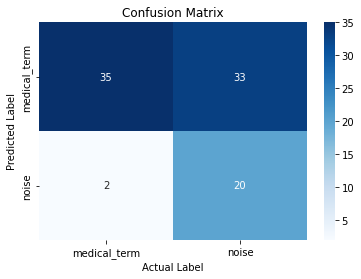

Precision: 0.5147058823529411
Recall: 0.9459459459459459
F1 Score: 0.6666666666666665


,Term,first_sentence,Term-Label,ner_results,entity_group
0,pcos,Polycystic ovary syndrome (PCOS) is a gynecological endocrine disorder and the leading cause of anovulatory female infertility.,medical_term,"[{'entity_group': 'problem', 'score': 0.99772024, 'word': 'polycystic ovary syndrome', 'start': 0, 'end': 25}, {'entity_group': 'problem', 'score': 0.7618345, 'word': 'pcos', 'start': 27, 'end': 31}, {'entity_group': 'problem', 'score': 0.99759185, 'word': 'a gynecological endocrine disorder', 'start': 36, 'end': 70}, {'entity_group': 'problem', 'score': 0.99686086, 'word': 'anovulatory female infertility', 'start': 96, 'end': 126}]",problem
1,infertility,The following describers were used: chlamydia trachomatis AND infertility ; chlamydia trachomatis AND tubal alteration AND infertility ; chlamydia AND low pregnancy rates .,medical_term,"[{'entity_group': 'problem', 'score': 0.99789596, 'word': 'ch', 'start': 36, 'end': 38}, {'entity_group': 'problem', 'score': 0.81548506, 'word': '##lam', 'start': 38, 'end': 41}, {'entity_group': 'problem', 'score': 0.989793, 'word': '##ydia trachomatis', 'start': 41, 'end': 57}, {'entity_group': 'problem', 'score': 0.8963201, 'word': 'infertility', 'start': 62, 'end': 73}, {'entity_group': 'problem', 'score': 0.9762119, 'word': 'chlamydia trachomatis', 'start': 76, 'end': 97}, {'entity_group': 'problem', 'score': 0.97652954, 'word': 'tubal alteration', 'start': 102, 'end': 118}, {'entity_group': 'problem', 'score': 0.93070024, 'word': 'infertility', 'start': 123, 'end': 134}, {'entity_group': 'problem', 'score': 0.9984616, 'word': 'ch', 'start': 137, 'end': 139}, {'entity_group': 'problem', 'score': 0.8138175, 'word': '##lamydia', 'start': 139, 'end': 146}, {'entity_group': 'problem', 'score': 0.9896622, 'word': 'low pregnancy rates', 'start': 151, 'end': 170}]",problem
2,women,"In the last 20 years, aspecific auto-immunity, defined as positivity of auto-antibodies in blood sample without clinical or biological criteria for defined diseases, has been evoked in a subpopulation of infertile women.",noise,"[{'entity_group': 'problem', 'score': 0.94838345, 'word': 'aspecifi', 'start': 22, 'end': 30}, {'entity_group': 'problem', 'score': 0.95245636, 'word': '##c auto - immunity', 'start': 30, 'end': 45}, {'entity_group': 'treatment', 'score': 0.4666759, 'word': 'auto - antibodies', 'start': 72, 'end': 87}, {'entity_group': 'test', 'score': 0.89714164, 'word': 'blood sample', 'start': 91, 'end': 103}, {'entity_group': 'problem', 'score': 0.97081536, 'word': 'defined diseases', 'start': 148, 'end': 164}]",None
3,sperm,"Clinical management for unexplained infertility includes expectant management as well as active treatments, including ovarian stimulation (OS), intrauterine insemination (IUI), OS-IUI, and in vitro fertilisation (IVF) with or without intracytoplasmic sperm injection (ICSI).Existing systematic reviews have conducted head-to-head comparisons of these interventions using pairwise meta-analyses.",medical_term,"[{'entity_group': 'problem', 'score': 0.9369788, 'word': 'unexplained infertility', 'start': 24, 'end': 47}, {'entity_group': 'treatment', 'score': 0.9880627, 'word': 'expectant management', 'start': 57, 'end': 77}, {'entity_group': 'treatment', 'score': 0.95092666, 'word': 'active treatments', 'start': 89, 'end': 106}, {'entity_group': 'treatment', 'score': 0.5480978, 'word': 'o', 'start': 118, 'end': 119}, {'entity_group': 'test', 'score': 0.5670822, 'word': '##varian stimulation', 'start': 119, 'end': 137}, {'entity_group': 'test', 'score': 0.2698966, 'word': 'os', 'start': 139, 'end': 141}, {'entity_group': 'treatment', 'score': 0.7922598, 'word': 'intrauterine insemination ( iui )', 'start': 144, 'end': 175}, {'entity_group': 'treatment', 'score': 0.64281476, 'word': 'os -', 'start': 177, 'end': 180}, {'entity_group': 'problem', 'score': 0.59972394, 'word': 'i', 'start': 180, 'end': 181}, {'entity_group': 'treatment', 'score': 0.39120924, 'word': '##ui', 'start': 181, 'end'

In [85]:
df = df.loc[:,'Term':'Term-Label']
tokenModelAndPipe("samrawal/bert-base-uncased_clinical-ner")
df['entity_group'] = df.apply(find_entity_group, axis=1)
df['entity_group'] = df['entity_group'].replace("test","problem")
df['entity_group'] = df['entity_group'].replace("treatment","problem")
label = get_entity_name() 
get_score_print(label) if label != "More than one entity_group corresponding to medical_term, please mark it manually." else print(label)
df.head(5)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


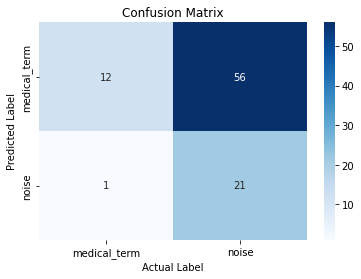

Precision: 0.17647058823529413
Recall: 0.9230769230769231
F1 Score: 0.29629629629629634


,Term,first_sentence,Term-Label,ner_results,entity_group
0,pcos,Polycystic ovary syndrome (PCOS) is a gynecological endocrine disorder and the leading cause of anovulatory female infertility.,medical_term,"[{'entity_group': 'B', 'score': 0.9950322, 'word': 'polycystic', 'start': 0, 'end': 10}, {'entity_group': 'I', 'score': 0.9945673, 'word': 'ovary syndrome', 'start': 11, 'end': 25}, {'entity_group': 'B', 'score': 0.9977151, 'word': 'pcos', 'start': 27, 'end': 31}, {'entity_group': 'B', 'score': 0.94890535, 'word': 'gynecological', 'start': 38, 'end': 51}, {'entity_group': 'I', 'score': 0.9777254, 'word': 'endocrine disorder', 'start': 52, 'end': 70}, {'entity_group': 'B', 'score': 0.76204085, 'word': 'anovulatory', 'start': 96, 'end': 107}, {'entity_group': 'I', 'score': 0.85134923, 'word': 'female infertility', 'start': 108, 'end': 126}]",I
1,infertility,The following describers were used: chlamydia trachomatis AND infertility ; chlamydia trachomatis AND tubal alteration AND infertility ; chlamydia AND low pregnancy rates .,medical_term,"[{'entity_group': 'B', 'score': 0.7993478, 'word': 'chlamydia', 'start': 36, 'end': 45}, {'entity_group': 'I', 'score': 0.6338692, 'word': 'trachomatis', 'start': 46, 'end': 57}, {'entity_group': 'B', 'score': 0.8955932, 'word': 'infertility', 'start': 62, 'end': 73}, {'entity_group': 'B', 'score': 0.86173177, 'word': 'chlamydia', 'start': 76, 'end': 85}, {'entity_group': 'I', 'score': 0.7152245, 'word': 'trachomatis', 'start': 86, 'end': 97}, {'entity_group': 'B', 'score': 0.70195776, 'word': 'tubal', 'start': 102, 'end': 107}, {'entity_group': 'I', 'score': 0.75747347, 'word': 'alteration', 'start': 108, 'end': 118}, {'entity_group': 'B', 'score': 0.88657653, 'word': 'infertility', 'start': 123, 'end': 134}, {'entity_group': 'B', 'score': 0.8587998, 'word': 'chlamydia', 'start': 137, 'end': 146}]",I
2,women,"In the last 20 years, aspecific auto-immunity, defined as positivity of auto-antibodies in blood sample without clinical or biological criteria for defined diseases, has been evoked in a subpopulation of infertile women.",noise,[],None
3,sperm,"Clinical management for unexplained infertility includes expectant management as well as active treatments, including ovarian stimulation (OS), intrauterine insemination (IUI), OS-IUI, and in vitro fertilisation (IVF) with or without intracytoplasmic sperm injection (ICSI).Existing systematic reviews have conducted head-to-head comparisons of these interventions using pairwise meta-analyses.",medical_term,"[{'entity_group': 'B', 'score': 0.9309964, 'word': 'unexplained', 'start': 24, 'end': 35}, {'entity_group': 'I', 'score': 0.96002287, 'word': 'infertility', 'start': 36, 'end': 47}]",None
4,review,"Hence, the goal of the present review is to contribute to a better elucidation of this matter.",medical_term,[],None


In [86]:
df = df.loc[:,'Term':'Term-Label']
tokenModelAndPipe("pruas/BENT-PubMedBERT-NER-Disease")
df['entity_group'] = df.apply(find_entity_group, axis=1)
df['entity_group'] = df['entity_group'].replace("B","I")
label = get_entity_name() 
get_score_print(label) if label != "More than one entity_group corresponding to medical_term, please mark it manually." else print(label)
df.head(5)

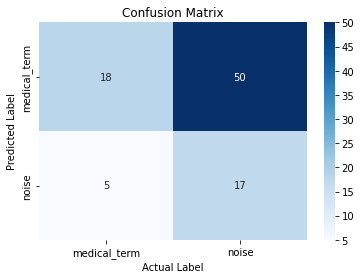

Precision: 0.2647058823529412
Recall: 0.782608695652174
F1 Score: 0.3956043956043956


,Term,first_sentence,Term-Label,ner_results,entity_group
0,pcos,Polycystic ovary syndrome (PCOS) is a gynecological endocrine disorder and the leading cause of anovulatory female infertility.,medical_term,"[{'entity_group': 'B_problem', 'score': 0.996249, 'word': 'poly', 'start': 0, 'end': 4}, {'entity_group': 'I_problem', 'score': 0.90711296, 'word': '##cystic ovary syndrome ( pcos', 'start': 4, 'end': 31}, {'entity_group': 'B_problem', 'score': 0.99586403, 'word': 'a', 'start': 36, 'end': 37}, {'entity_group': 'I_problem', 'score': 0.99755335, 'word': 'gynecological endocrine disorder', 'start': 38, 'end': 70}, {'entity_group': 'B_problem', 'score': 0.998944, 'word': 'an', 'start': 96, 'end': 98}, {'entity_group': 'I_problem', 'score': 0.9928884, 'word': '##ovulatory female infertility', 'start': 98, 'end': 126}]",None
1,infertility,The following describers were used: chlamydia trachomatis AND infertility ; chlamydia trachomatis AND tubal alteration AND infertility ; chlamydia AND low pregnancy rates .,medical_term,"[{'entity_group': 'B_problem', 'score': 0.9985373, 'word': 'ch', 'start': 36, 'end': 38}, {'entity_group': 'I_problem', 'score': 0.9625131, 'word': '##lamydia trachomatis', 'start': 38, 'end': 57}, {'entity_group': 'B_problem', 'score': 0.9809459, 'word': 'infer', 'start': 62, 'end': 67}, {'entity_group': 'I_problem', 'score': 0.9693253, 'word': '##tility', 'start': 67, 'end': 73}, {'entity_group': 'B_problem', 'score': 0.99870265, 'word': 'ch', 'start': 76, 'end': 78}, {'entity_group': 'I_problem', 'score': 0.99063224, 'word': '##lamydia trachomatis', 'start': 78, 'end': 97}, {'entity_group': 'B_problem', 'score': 0.991911, 'word': 'tuba', 'start': 102, 'end': 106}, {'entity_group': 'I_problem', 'score': 0.99676573, 'word': '##l alteration', 'start': 106, 'end': 118}, {'entity_group': 'B_problem', 'score': 0.9510732, 'word': 'infertility', 'start': 123, 'end': 134}, {'entity_group': 'B_problem', 'score': 0.9988133, 'word': 'ch', 'start': 137, 'end': 139}, {'entity_group': 'I_problem', 'score': 0.91737795, 'word': '##lamydia', 'start': 139, 'end': 146}, {'entity_group': 'B_problem', 'score': 0.9771902, 'word': 'low', 'start': 151, 'end': 154}, {'entity_group': 'I_problem', 'score': 0.9975432, 'word': 'pregnancy rates', 'start': 155, 'end': 170}]",I_problem
2,women,"In the last 20 years, aspecific auto-immunity, defined as positivity of auto-antibodies in blood sample without clinical or biological criteria for defined diseases, has been evoked in a subpopulation of infertile women.",noise,"[{'entity_group': 'B_problem', 'score': 0.9795324, 'word': 'as', 'start': 22, 'end': 24}, {'entity_group': 'I_problem', 'score': 0.9379655, 'word': '##pecific auto - immunity', 'start': 24, 'end': 45}, {'entity_group': 'B_problem', 'score': 0.9632263, 'word': 'po', 'start': 58, 'end': 60}, {'entity_group': 'I_problem', 'score': 0.8775719, 'word': '##sit', 'start': 60, 'end': 63}, {'entity_group': 'I_problem', 'score': 0.5910243, 'word': 'of auto - antibodies', 'start': 69, 'end': 87}, {'entity_group': 'B_test', 'score': 0.96764404, 'word': 'blood', 'start': 91, 'end': 96}, {'entity_group': 'I_test', 'score': 0.94362295, 'word': 'sample', 'start': 97, 'end': 103}, {'entity_group': 'B_problem', 'score': 0.9437961, 'word': 'defined', 'start': 148, 'end': 155}, {'entity_group': 'I_problem', 'score': 0.98465675, 'word': 'diseases', 'start': 156, 'end': 164}]",None
3,sperm,"Clinical management for unexplained infertility includes expectant management as well as active treatments, including ovarian stimulation (OS), intrauterine insemination (IUI), OS-IUI, and in vitro fertilisation (IVF) with or without intracytoplasmic sperm injection (ICSI).Existing systematic reviews have conducted head-to-head comparisons of these interventions using pairwise meta-analyses.",medical_term,"[{'entity_group': 'B_problem', 'score': 0.99748945, 'word': 'une', 'start': 24, 'end': 27}, {'entity_group': 'I_problem', 'score': 0.9943067, 'word': '##xplaine

In [87]:
df = df.loc[:,'Term':'Term-Label']
tokenModelAndPipe("medical-ner-proj/bert-medical-ner-proj")
df['entity_group'] = df.apply(find_entity_group, axis=1)
df['entity_group'] = df['entity_group'].replace("I_test","I_problem")
df['entity_group'] = df['entity_group'].replace("B_problem","I_problem")
df['entity_group'] = df['entity_group'].replace("I_treatment","I_problem")
df['entity_group'] = df['entity_group'].replace("B_person", None)
df['entity_group'] = df['entity_group'].replace("B_treatment","I_problem")
df['entity_group'] = df['entity_group'].replace("B_test","I_problem")
label = get_entity_name() 
get_score_print(label) if label != "More than one entity_group corresponding to medical_term, please mark it manually." else print(label)
df.head(5)

ELECTRA

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


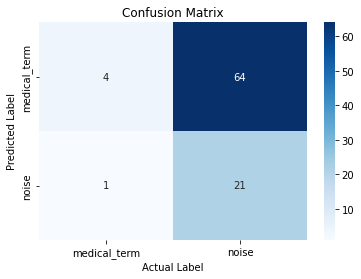

Precision: 0.058823529411764705
Recall: 0.8
F1 Score: 0.1095890410958904


,Term,first_sentence,Term-Label,ner_results,entity_group
0,pcos,Polycystic ovary syndrome (PCOS) is a gynecological endocrine disorder and the leading cause of anovulatory female infertility.,medical_term,"[{'entity_group': 'Participants', 'score': 0.5790503, 'word': '##ovulatory female infertility', 'start': 98, 'end': 126}]",None
1,infertility,The following describers were used: chlamydia trachomatis AND infertility ; chlamydia trachomatis AND tubal alteration AND infertility ; chlamydia AND low pregnancy rates .,medical_term,[],None
2,women,"In the last 20 years, aspecific auto-immunity, defined as positivity of auto-antibodies in blood sample without clinical or biological criteria for defined diseases, has been evoked in a subpopulation of infertile women.",noise,"[{'entity_group': 'Participants', 'score': 0.90625477, 'word': 'infertile women.', 'start': 204, 'end': 220}]",None
3,sperm,"Clinical management for unexplained infertility includes expectant management as well as active treatments, including ovarian stimulation (OS), intrauterine insemination (IUI), OS-IUI, and in vitro fertilisation (IVF) with or without intracytoplasmic sperm injection (ICSI).Existing systematic reviews have conducted head-to-head comparisons of these interventions using pairwise meta-analyses.",medical_term,"[{'entity_group': 'Intervention', 'score': 0.9046978, 'word': 'ovarian stimulation ( os ), intrauterine insemination ( iui ), os - iui, and in vitro fertilisation ( ivf ) with or without intracytoplasmic sperm injection ( icsi )', 'start': 118, 'end': 273}]",None
4,review,"Hence, the goal of the present review is to contribute to a better elucidation of this matter.",medical_term,[],None


In [88]:
df = df.loc[:,'Term':'Term-Label']
tokenModelAndPipe("kamalkraj/BioELECTRA-PICO")
df['entity_group'] = df.apply(find_entity_group, axis=1)
df['entity_group'] = df['entity_group'].replace("Intervention","Outcome")
label = get_entity_name() 
get_score_print(label) if label != "More than one entity_group corresponding to medical_term, please mark it manually." else print(label)
df.head(5)

ALBERT

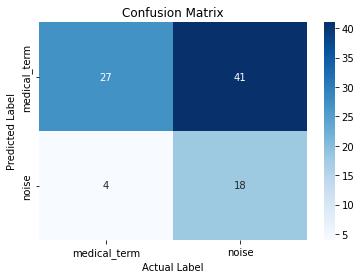

Precision: 0.39705882352941174
Recall: 0.8709677419354839
F1 Score: 0.5454545454545454


,Term,first_sentence,Term-Label,ner_results,entity_group
0,pcos,Polycystic ovary syndrome (PCOS) is a gynecological endocrine disorder and the leading cause of anovulatory female infertility.,medical_term,"[{'entity_group': 'B_problem', 'score': 0.9981464, 'word': 'poly', 'start': 0, 'end': 4}, {'entity_group': 'I_problem', 'score': 0.9622114, 'word': 'cystic ovary syndrome ', 'start': 4, 'end': 27}, {'entity_group': 'I_problem', 'score': 0.8693036, 'word': 'pcos', 'start': 27, 'end': 31}, {'entity_group': 'B_problem', 'score': 0.98861736, 'word': 'a', 'start': 36, 'end': 37}, {'entity_group': 'I_problem', 'score': 0.9935729, 'word': 'gynecological endocrine disorder', 'start': 38, 'end': 70}, {'entity_group': 'B_problem', 'score': 0.9943098, 'word': '', 'start': 96, 'end': 97}, {'entity_group': 'I_problem', 'score': 0.9881594, 'word': 'anovulatory female infertility', 'start': 96, 'end': 126}]",I_problem
1,infertility,The following describers were used: chlamydia trachomatis AND infertility ; chlamydia trachomatis AND tubal alteration AND infertility ; chlamydia AND low pregnancy rates .,medical_term,"[{'entity_group': 'B_problem', 'score': 0.99756765, 'word': 'ch', 'start': 36, 'end': 38}, {'entity_group': 'I_problem', 'score': 0.937053, 'word': 'lamydia trachomatis', 'start': 38, 'end': 57}, {'entity_group': 'B_problem', 'score': 0.9840576, 'word': 'in', 'start': 62, 'end': 64}, {'entity_group': 'I_problem', 'score': 0.9879196, 'word': 'fertility', 'start': 64, 'end': 73}, {'entity_group': 'B_problem', 'score': 0.9966876, 'word': 'ch', 'start': 76, 'end': 78}, {'entity_group': 'I_problem', 'score': 0.9884076, 'word': 'lamydia trachomatis', 'start': 78, 'end': 97}, {'entity_group': 'B_problem', 'score': 0.98688704, 'word': 'tub', 'start': 102, 'end': 105}, {'entity_group': 'I_problem', 'score': 0.9973969, 'word': 'al alteration', 'start': 105, 'end': 118}, {'entity_group': 'B_problem', 'score': 0.90323293, 'word': 'in', 'start': 123, 'end': 125}, {'entity_group': 'I_problem', 'score': 0.9813316, 'word': 'fertility', 'start': 125, 'end': 134}, {'entity_group': 'B_problem', 'score': 0.99599576, 'word': 'ch', 'start': 137, 'end': 139}, {'entity_group': 'I_problem', 'score': 0.9948516, 'word': 'lamydia', 'start': 139, 'end': 146}, {'entity_group': 'B_problem', 'score': 0.9919973, 'word': 'low', 'start': 151, 'end': 154}, {'entity_group': 'I_problem', 'score': 0.99551344, 'word': 'pregnancy rates', 'start': 155, 'end': 170}]",None
2,women,"In the last 20 years, aspecific auto-immunity, defined as positivity of auto-antibodies in blood sample without clinical or biological criteria for defined diseases, has been evoked in a subpopulation of infertile women.",noise,"[{'entity_group': 'B_problem', 'score': 0.9896861, 'word': 'a', 'start': 22, 'end': 23}, {'entity_group': 'I_problem', 'score': 0.9914318, 'word': 'specific auto-immunity', 'start': 23, 'end': 45}, {'entity_group': 'B_problem', 'score': 0.6809916, 'word': '', 'start': 58, 'end': 59}, {'entity_group': 'B_problem', 'score': 0.7195372, 'word': 'auto', 'start': 72, 'end': 76}, {'entity_group': 'I_problem', 'score': 0.95107347, 'word': '-antibodies', 'start': 76, 'end': 87}, {'entity_group': 'B_test', 'score': 0.8455058, 'word': 'blood', 'start': 91, 'end': 96}, {'entity_group': 'I_test', 'score': 0.96213853, 'word': 'sample', 'start': 97, 'end': 103}, {'entity_group': 'B_problem', 'score': 0.94890946, 'word': 'defined', 'start': 148, 'end': 155}, {'entity_group': 'I_problem', 'score': 0.99096674, 'word': 'diseases', 'start': 156, 'end': 164}]",None
3,sperm,"Clinical management for unexplained infertility includes expectant management as well as active treatments, including ovarian stimulation (OS), intrauterine insemination (IUI), OS-IUI, and in vitro fertilisation (IVF) with or without intracytoplasmic sperm injection (ICSI).Existing systematic reviews have conducted head-to-head comparisons of these interventions using pairwise meta-analyses.",medical_term,"[{'entity_grou

In [89]:
df = df.loc[:,'Term':'Term-Label']
tokenModelAndPipe("medical-ner-proj/albert-medical-ner-proj")
df['entity_group'] = df.apply(find_entity_group, axis=1)
df['entity_group'] = df['entity_group'].replace("I_treatment","I_problem")
df['entity_group'] = df['entity_group'].replace("I_test","I_problem")
df['entity_group'] = df['entity_group'].replace("B_test","I_problem")
df['entity_group'] = df['entity_group'].replace("B_treatment","I_problem")
df['entity_group'] = df['entity_group'].replace("B_problem","I_problem")
label = get_entity_name() 
get_score_print(label) if label != "More than one entity_group corresponding to medical_term, please mark it manually." else print(label)
df.head(5)

roBERTa

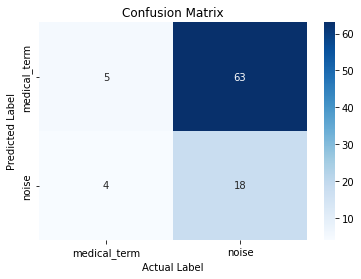

Precision: 0.07352941176470588
Recall: 0.5555555555555556
F1 Score: 0.12987012987012989


,Term,first_sentence,Term-Label,ner_results,entity_group
0,pcos,Polycystic ovary syndrome (PCOS) is a gynecological endocrine disorder and the leading cause of anovulatory female infertility.,medical_term,"[{'entity_group': 'DISO', 'score': 0.9937171, 'word': ' Pol', 'start': 0, 'end': 3}, {'entity_group': 'DISO', 'score': 0.99318224, 'word': 'yc', 'start': 3, 'end': 5}, {'entity_group': 'DISO', 'score': 0.9942661, 'word': 'ys', 'start': 5, 'end': 7}, {'entity_group': 'DISO', 'score': 0.8426779, 'word': 'tic ovary syndrome', 'start': 7, 'end': 25}, {'entity_group': 'DISO', 'score': 0.9904835, 'word': 'PC', 'start': 27, 'end': 29}, {'entity_group': 'DISO', 'score': 0.991991, 'word': 'OS', 'start': 29, 'end': 31}, {'entity_group': 'DISO', 'score': 0.46531105, 'word': ' endocrine', 'start': 52, 'end': 61}, {'entity_group': 'DISO', 'score': 0.5690255, 'word': ' disorder', 'start': 62, 'end': 70}, {'entity_group': 'DISO', 'score': 0.95919573, 'word': ' ano', 'start': 96, 'end': 99}, {'entity_group': 'DISO', 'score': 0.6091512, 'word': 'vulatory female infertility', 'start': 99, 'end': 126}]",None
1,infertility,The following describers were used: chlamydia trachomatis AND infertility ; chlamydia trachomatis AND tubal alteration AND infertility ; chlamydia AND low pregnancy rates .,medical_term,"[{'entity_group': 'DISO', 'score': 0.530697, 'word': ' ch', 'start': 36, 'end': 38}, {'entity_group': 'DISO', 'score': 0.76350874, 'word': 'lamy', 'start': 38, 'end': 42}, {'entity_group': 'DISO', 'score': 0.67626935, 'word': 'dia', 'start': 42, 'end': 45}, {'entity_group': 'DISO', 'score': 0.9976076, 'word': ' infer', 'start': 62, 'end': 67}, {'entity_group': 'DISO', 'score': 0.99768, 'word': 'til', 'start': 67, 'end': 70}, {'entity_group': 'DISO', 'score': 0.9966953, 'word': 'ity', 'start': 70, 'end': 73}, {'entity_group': 'DISO', 'score': 0.76415235, 'word': 'lamy', 'start': 78, 'end': 82}, {'entity_group': 'DISO', 'score': 0.6456431, 'word': 'dia', 'start': 82, 'end': 85}, {'entity_group': 'DISO', 'score': 0.5416404, 'word': ' trachomatis', 'start': 86, 'end': 97}, {'entity_group': 'DISO', 'score': 0.99428576, 'word': ' infer', 'start': 123, 'end': 128}, {'entity_group': 'DISO', 'score': 0.9958715, 'word': 'til', 'start': 128, 'end': 131}, {'entity_group': 'DISO', 'score': 0.99467933, 'word': 'ity', 'start': 131, 'end': 134}, {'entity_group': 'DISO', 'score': 0.809791, 'word': ' ch', 'start': 137, 'end': 139}, {'entity_group': 'DISO', 'score': 0.9174927, 'word': 'lamy', 'start': 139, 'end': 143}, {'entity_group': 'DISO', 'score': 0.82664084, 'word': 'dia', 'start': 143, 'end': 146}]",None
2,women,"In the last 20 years, aspecific auto-immunity, defined as positivity of auto-antibodies in blood sample without clinical or biological criteria for defined diseases, has been evoked in a subpopulation of infertile women.",noise,"[{'entity_group': 'PROC', 'score': 0.99337584, 'word': ' auto', 'start': 72, 'end': 76}, {'entity_group': 'PROC', 'score': 0.98645276, 'word': '-', 'start': 76, 'end': 77}, {'entity_group': 'PROC', 'score': 0.9958371, 'word': 'anti', 'start': 77, 'end': 81}, {'entity_group': 'PROC', 'score': 0.9926819, 'word': 'bo', 'start': 81, 'end': 83}, {'entity_group': 'PROC', 'score': 0.9918309, 'word': 'dies', 'start': 83, 'end': 87}, {'entity_group': 'ANAT', 'score': 0.7836339, 'word': ' blood', 'start': 91, 'end': 96}, {'entity_group': 'PROC', 'score': 0.934628, 'word': ' sample', 'start': 97, 'end': 103}, {'entity_group': 'DISO', 'score': 0.99636793, 'word': ' diseases', 'start': 156, 'end': 164}]",None
3,sperm,"Clinical management for unexplained infertility includes expectant management as well as active treatments, including ovarian stimulation (OS), intrauterine insemination (IUI), OS-IUI, and in vitro fertilisation (IVF) with or without intracytoplasmic sperm injection (ICSI).Existing systematic reviews have conducted head-to-head comparisons of these interventions using pairwise meta-analyses.",medical_term,"[{'entity_gro

In [90]:
df = df.loc[:,'Term':'Term-Label']
tokenModelAndPipe("lcampillos/roberta-es-clinical-trials-ner")
df['entity_group'] = df.apply(find_entity_group, axis=1)
df['entity_group'] = df['entity_group'].replace("PROC","DISO")
label = get_entity_name() 
get_score_print(label) if label != "More than one entity_group corresponding to medical_term, please mark it manually." else print(label)
df.head(5)

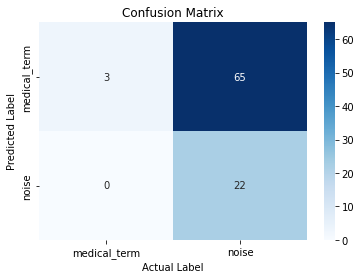

Precision: 0.04411764705882353
Recall: 1.0
F1 Score: 0.08450704225352113


,Term,first_sentence,Term-Label,ner_results,entity_group
0,pcos,Polycystic ovary syndrome (PCOS) is a gynecological endocrine disorder and the leading cause of anovulatory female infertility.,medical_term,"[{'entity_group': 'Chemical', 'score': 0.79837024, 'word': ' endocr', 'start': 52, 'end': 58}]",None
1,infertility,The following describers were used: chlamydia trachomatis AND infertility ; chlamydia trachomatis AND tubal alteration AND infertility ; chlamydia AND low pregnancy rates .,medical_term,[],None
2,women,"In the last 20 years, aspecific auto-immunity, defined as positivity of auto-antibodies in blood sample without clinical or biological criteria for defined diseases, has been evoked in a subpopulation of infertile women.",noise,"[{'entity_group': 'GENE', 'score': 0.8788243, 'word': ' auto', 'start': 72, 'end': 76}, {'entity_group': 'GENE', 'score': 0.92221856, 'word': 'anti', 'start': 77, 'end': 81}, {'entity_group': 'GENE', 'score': 0.87682736, 'word': 'bo', 'start': 81, 'end': 83}, {'entity_group': 'GENE', 'score': 0.93683845, 'word': 'dies', 'start': 83, 'end': 87}]",None
3,sperm,"Clinical management for unexplained infertility includes expectant management as well as active treatments, including ovarian stimulation (OS), intrauterine insemination (IUI), OS-IUI, and in vitro fertilisation (IVF) with or without intracytoplasmic sperm injection (ICSI).Existing systematic reviews have conducted head-to-head comparisons of these interventions using pairwise meta-analyses.",medical_term,"[{'entity_group': 'GENE', 'score': 0.69772416, 'word': 'cytoplasmic', 'start': 239, 'end': 250}, {'entity_group': 'Cell', 'score': 0.93938535, 'word': ' sperm', 'start': 251, 'end': 256}]",Cell
4,review,"Hence, the goal of the present review is to contribute to a better elucidation of this matter.",medical_term,[],None


In [91]:
df = df.loc[:,'Term':'Term-Label']
tokenModelAndPipe("StivenLancheros/roberta-base-biomedical-clinical-es-finetuned-ner-CRAFT")
df['entity_group'] = df.apply(find_entity_group, axis=1)
df['entity_group'] = df['entity_group'].replace("Protein","Cell")
label = get_entity_name() 
get_score_print(label) if label != "More than one entity_group corresponding to medical_term, please mark it manually." else print(label)
df.head(5)

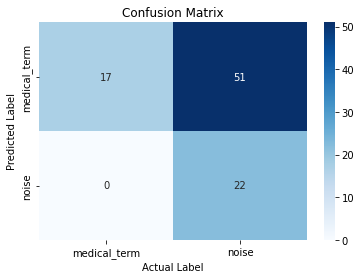

Precision: 0.25
Recall: 1.0
F1 Score: 0.4


,Term,first_sentence,Term-Label,ner_results,entity_group
0,pcos,Polycystic ovary syndrome (PCOS) is a gynecological endocrine disorder and the leading cause of anovulatory female infertility.,medical_term,"[{'entity_group': 'Health_Problem', 'score': 0.9585516, 'word': ' Poly', 'start': 0, 'end': 4}, {'entity_group': 'Health_Problem', 'score': 0.95016503, 'word': 'cy', 'start': 4, 'end': 6}, {'entity_group': 'Health_Problem', 'score': 0.9514391, 'word': 'stic', 'start': 6, 'end': 10}, {'entity_group': 'Medical_History', 'score': 0.45507354, 'word': ' ov', 'start': 11, 'end': 13}, {'entity_group': 'Health_Problem', 'score': 0.6068053, 'word': 'ary syndrome (', 'start': 13, 'end': 27}, {'entity_group': 'Health_Problem', 'score': 0.36906514, 'word': 'PCOS)', 'start': 27, 'end': 32}, {'entity_group': 'Health_Problem', 'score': 0.6854013, 'word': ' gy', 'start': 38, 'end': 40}, {'entity_group': 'Health_Problem', 'score': 0.77442837, 'word': 'nec', 'start': 40, 'end': 43}, {'entity_group': 'Health_Problem', 'score': 0.7500195, 'word': 'ological', 'start': 43, 'end': 51}, {'entity_group': 'Medical_History', 'score': 0.46677923, 'word': ' endocrine', 'start': 52, 'end': 61}, {'entity_group': 'Health_Problem', 'score': 0.5862481, 'word': ' disorder', 'start': 62, 'end': 70}, {'entity_group': 'Health_Problem', 'score': 0.9114129, 'word': ' an', 'start': 96, 'end': 98}, {'entity_group': 'Health_Problem', 'score': 0.84323865, 'word': 'ov', 'start': 98, 'end': 100}, {'entity_group': 'Health_Problem', 'score': 0.8856372, 'word': 'ulatory female infertility', 'start': 100, 'end': 126}]",None
1,infertility,The following describers were used: chlamydia trachomatis AND infertility ; chlamydia trachomatis AND tubal alteration AND infertility ; chlamydia AND low pregnancy rates .,medical_term,"[{'entity_group': 'Health_Problem', 'score': 0.810202, 'word': ' ch', 'start': 36, 'end': 38}, {'entity_group': 'Health_Problem', 'score': 0.8477078, 'word': 'lam', 'start': 38, 'end': 41}, {'entity_group': 'Health_Problem', 'score': 0.86241347, 'word': 'ydia', 'start': 41, 'end': 45}, {'entity_group': 'Procedure_Name', 'score': 0.89757574, 'word': ' trachomatis AND', 'start': 46, 'end': 61}, {'entity_group': 'Health_Problem', 'score': 0.31583285, 'word': ' infertility', 'start': 62, 'end': 73}, {'entity_group': 'Health_Problem', 'score': 0.80885977, 'word': ' ch', 'start': 76, 'end': 78}, {'entity_group': 'Health_Problem', 'score': 0.87218976, 'word': 'lam', 'start': 78, 'end': 81}, {'entity_group': 'Health_Problem', 'score': 0.90501094, 'word': 'ydia', 'start': 81, 'end': 85}, {'entity_group': 'Procedure_Name', 'score': 0.8545251, 'word': ' trachomatis AND tubal alteration', 'start': 86, 'end': 118}, {'entity_group': 'Health_Problem', 'score': 0.33017924, 'word': ' infertility', 'start': 123, 'end': 134}, {'entity_group': 'Health_Problem', 'score': 0.89811635, 'word': ' ch', 'start': 137, 'end': 139}, {'entity_group': 'Health_Problem', 'score': 0.930486, 'word': 'lam', 'start': 139, 'end': 142}, {'entity_group': 'Health_Problem', 'score': 0.9509663, 'word': 'ydia', 'start': 142, 'end': 146}, {'entity_group': 'Health_Problem', 'score': 0.38064405, 'word': ' low', 'start': 151, 'end': 154}, {'entity_group': 'Medical_History', 'score': 0.35035074, 'word': ' pregnancy', 'start': 155, 'end': 164}, {'entity_group': 'Procedure_Name', 'score': 0.17998855, 'word': ' rates', 'start': 165, 'end': 170}]",Health_Problem
2,women,"In the last 20 years, aspecific auto-immunity, defined as positivity of auto-antibodies in blood sample without clinical or biological criteria for defined diseases, has been evoked in a subpopulation of infertile women.",noise,"[{'entity_group': 'Health_Problem', 'score': 0.353054, 'word': ' as', 'start': 22, 'end': 24}, {'entity_group': 'Health_Problem', 'score': 0.44432914, 'word': 'pe', 'start': 24, 'end': 26}, {'entity_group': 'Health_Problem', 'score': 0.55483174, 'word': 'cific', 'start': 26, 'end': 31}, {'entity_group': 'Health_Problem

In [92]:
df = df.loc[:,'Term':'Term-Label']
tokenModelAndPipe("silpakanneganti/roberta-cpt-medical-ner")
df['entity_group'] = df.apply(find_entity_group, axis=1)
df['entity_group'] = df['entity_group'].replace("Medical_History","Health_Problem")
df['entity_group'] = df['entity_group'].replace("Procedure_Name","Health_Problem")
df['entity_group'] = df['entity_group'].replace("Medication","Health_Problem")
label = get_entity_name() 
get_score_print(label) if label != "More than one entity_group corresponding to medical_term, please mark it manually." else print(label)
df.head(5)

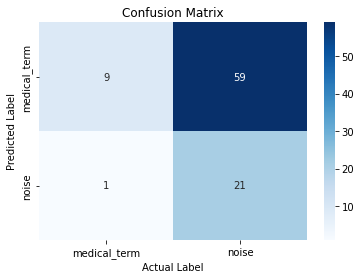

Precision: 0.1323529411764706
Recall: 0.9
F1 Score: 0.23076923076923075


,Term,first_sentence,Term-Label,ner_results,entity_group
0,pcos,Polycystic ovary syndrome (PCOS) is a gynecological endocrine disorder and the leading cause of anovulatory female infertility.,medical_term,"[{'entity_group': 'Disease', 'score': 0.9498687, 'word': ' Polycystic ovary syndrome', 'start': 0, 'end': 25}, {'entity_group': 'Disease', 'score': 0.8443469, 'word': 'PCOS', 'start': 27, 'end': 31}, {'entity_group': 'Disease', 'score': 0.61063665, 'word': ' gy', 'start': 38, 'end': 40}, {'entity_group': 'Disease', 'score': 0.78884244, 'word': 'ological endocrine disorder', 'start': 43, 'end': 70}, {'entity_group': 'Disease', 'score': 0.7480954, 'word': ' anovulatory female infertility', 'start': 96, 'end': 126}]",None
1,infertility,The following describers were used: chlamydia trachomatis AND infertility ; chlamydia trachomatis AND tubal alteration AND infertility ; chlamydia AND low pregnancy rates .,medical_term,"[{'entity_group': 'Disease', 'score': 0.928256, 'word': ' chlamydia trachomatis', 'start': 36, 'end': 57}, {'entity_group': 'Disease', 'score': 0.66868234, 'word': ' infertility', 'start': 62, 'end': 73}, {'entity_group': 'Disease', 'score': 0.9210649, 'word': ' chlamydia trachomatis', 'start': 76, 'end': 97}, {'entity_group': 'Disease', 'score': 0.7355862, 'word': ' infertility', 'start': 123, 'end': 134}, {'entity_group': 'Disease', 'score': 0.84809875, 'word': ' chlamydia', 'start': 137, 'end': 146}]",Disease
2,women,"In the last 20 years, aspecific auto-immunity, defined as positivity of auto-antibodies in blood sample without clinical or biological criteria for defined diseases, has been evoked in a subpopulation of infertile women.",noise,"[{'entity_group': 'Disease', 'score': 0.8446208, 'word': ' auto-immunity', 'start': 32, 'end': 45}]",None
3,sperm,"Clinical management for unexplained infertility includes expectant management as well as active treatments, including ovarian stimulation (OS), intrauterine insemination (IUI), OS-IUI, and in vitro fertilisation (IVF) with or without intracytoplasmic sperm injection (ICSI).Existing systematic reviews have conducted head-to-head comparisons of these interventions using pairwise meta-analyses.",medical_term,"[{'entity_group': 'Disease', 'score': 0.723516, 'word': ' infertility', 'start': 36, 'end': 47}]",None
4,review,"Hence, the goal of the present review is to contribute to a better elucidation of this matter.",medical_term,[],None


In [93]:
df = df.loc[:,'Term':'Term-Label']
tokenModelAndPipe("raynardj/ner-disease-ncbi-bionlp-bc5cdr-pubmed")
df['entity_group'] = df.apply(find_entity_group, axis=1)
label = get_entity_name() 
get_score_print(label) if label != "More than one entity_group corresponding to medical_term, please mark it manually." else print(label)
df.head(5)